In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import numpy as np 
import random
import warnings
import time
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA


!pip install pytorch-model-summary
from pytorch_model_summary import summary as summary

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)
set_seed(0)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
path = '/content/drive/My Drive/hw10'
# path = './'


# Preparation

## Data

In [0]:
class ImgDataset(data.Dataset):

    def __init__(self, data, mode):
  
        if mode == 'cnn' or mode =='cnnv2':
            data = data.transpose([0,3,1,2])
        else:
            data = data.reshape(len(data), -1)

        self.data = data
        self.mode = mode

    def __getitem__(self, i):
        return self.data[i]

    def __len__(self):
        return len(self.data)
    
def get_dataloader(dataset, mode = 'train', batch_size = 128):
    shuffle  = True if mode == 'train' else False
    loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

In [0]:
train = np.load(os.path.join(path, 'train.npy'), allow_pickle=True)
test = np.load(os.path.join(path, 'test.npy'), allow_pickle=True)

## Model

In [0]:
class fcn_autoencoder(nn.Module):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(32 * 32 * 3, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), nn.Linear(128, 32 * 32 * 3
            ), nn.Tanh())

    def forward(self, x):
        code = self.encoder(x)
        x_rec = self.decoder(code)
        return code, x_rec

In [6]:
model = fcn_autoencoder().to(device)
print(summary(model, torch.zeros((1, 3*32*32)).to(device), show_hierarchical=True))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1            [1, 128]         393,344         393,344
            ReLU-2            [1, 128]               0               0
          Linear-3             [1, 64]           8,256           8,256
            ReLU-4             [1, 64]               0               0
          Linear-5             [1, 12]             780             780
            ReLU-6             [1, 12]               0               0
          Linear-7              [1, 3]              39              39
          Linear-8             [1, 12]              48              48
            ReLU-9             [1, 12]               0               0
         Linear-10             [1, 64]             832             832
           ReLU-11             [1, 64]               0               0
         Linear-12            [1, 128]           8,320           8,320
     

In [0]:
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			      nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
    # 			nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
    #       nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
#             nn.ReLU(),
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Tanh(),
        )

    def forward(self, x):
        # print(x.dtype)
        code = self.encoder(x)
        x_rec = self.decoder(code)
        return code,x_rec

In [8]:
model = conv_autoencoder().to(device)
print(summary(model, torch.zeros((1, 3,32,32)).to(device), show_hierarchical=True))

--------------------------------------------------------------------------
         Layer (type)        Output Shape         Param #     Tr. Param #
             Conv2d-1     [1, 12, 16, 16]             588             588
               ReLU-2     [1, 12, 16, 16]               0               0
             Conv2d-3       [1, 24, 8, 8]           4,632           4,632
               ReLU-4       [1, 24, 8, 8]               0               0
             Conv2d-5       [1, 48, 4, 4]          18,480          18,480
               ReLU-6       [1, 48, 4, 4]               0               0
    ConvTranspose2d-7       [1, 24, 8, 8]          18,456          18,456
               ReLU-8       [1, 24, 8, 8]               0               0
    ConvTranspose2d-9     [1, 12, 16, 16]           4,620           4,620
              ReLU-10     [1, 12, 16, 16]               0               0
   ConvTranspose2d-11      [1, 3, 32, 32]             579             579
              Tanh-12      [1, 3, 32,

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(32*32*3, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 32*32*3)

    def encode(self, x):
    
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(logvar * 0.5)
        e = torch.tensor(np.random.normal(size = std.size())).to(device, dtype=torch.float)
        return std * e + mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        # print(z.dtype)
        x_rec = self.decode(z)
        return  z, (x_rec, mu, logvar)

In [10]:
model = VAE().to(device)
print(summary(model, torch.zeros((1, 3*32*32)).to(device), show_hierarchical=True))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1            [1, 400]       1,229,200       1,229,200
          Linear-2             [1, 20]           8,020           8,020
          Linear-3             [1, 20]           8,020           8,020
          Linear-4            [1, 400]           8,400           8,400
          Linear-5           [1, 3072]       1,231,872       1,231,872
Total params: 2,485,512
Trainable params: 2,485,512
Non-trainable params: 0
-----------------------------------------------------------------------


============================== Hierarchical Summary ==============================

VAE(
  (fc1): Linear(in_features=3072, out_features=400, bias=True), 1,229,200 params
  (fc21): Linear(in_features=400, out_features=20, bias=True), 8,020 params
  (fc22): Linear(in_features=400, out_features=20, bias=True), 8,020 params
  (fc3): Linear(in_features=20

## Train

In [0]:
def loss_vae(output, x):
    """
    rec_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    rec_x, mu, logvar = output
    mse = nn.MSELoss(reduction = 'sum')(rec_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = torch.sum(logvar.exp() - (1 + logvar) + (mu**2)) * (0.5)
    # KLD = torch.sum(-(logvar.exp()+(mu**2)) + (1 + logvar) ) * (-0.5)
    return mse + KLD


In [0]:
def run_epoch(model, dataloader, criterion, optimizer, run_mode, model_mode, best_loss = np.inf):
    epoch_loss = 0
    codes, x_recs = [],[]
    for x_batch in dataloader:
        x_batch = x_batch.to(device, dtype = torch.float)
        # ===================forward=====================
        code, output = model(x_batch)
        # if model_type == 'vae':
        # loss = loss_vae(output[0], img, output[1], output[2], criterion)
        # else:
        loss = criterion(output, x_batch)
        epoch_loss += loss.item()
        # ===================backward====================
        if run_mode == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # ===================save====================
            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(model, os.path.join(path, 'best_model_{}.pt'.format(model_mode)))
        # 重构x，code记录
        x_rec = output if model_mode != 'vae' else output[0]
        x_rec = x_rec.permute(0, 2, 3, 1) if model_mode == 'cnn' or model_mode=='cnnv2' else x_rec.reshape(-1, 32, 32, 3)
        codes.append(code)
        x_recs.append(x_rec)
        
    x_recs = torch.cat(x_recs).cpu().detach().numpy()
    codes = torch.cat(codes).cpu().detach().numpy().reshape(len(x_recs), -1)
    
    
        
    return epoch_loss, (codes, x_recs)


In [0]:
def train_process(mode, learning_rate, batch_size, num_epochs):
    set_seed(0)
    train_set = ImgDataset(train, mode = mode)
    loader = get_dataloader(train_set, mode = mode, batch_size=batch_size)
    model_classes = {'fcn':fcn_autoencoder(), 'cnn':conv_autoencoder(), 'vae':VAE(), 'cnnv2':conv_autoencoder()}
    model = model_classes[mode].to(device)
    criterion = nn.MSELoss(reduction = 'sum') if mode != 'vae' else loss_vae
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    for epoch in range(1, num_epochs+1):
        st = time.time()
        model.train()
        epoch_loss,_ = run_epoch(model, loader, criterion, optimizer, 'train', mode)
        ed = time.time()
        print('{:.2f}s,epoch [{:0>3d}/{}], loss: {:.8f}'
            .format(ed-st, epoch, num_epochs, epoch_loss/len(train_set)))
    return model

In [0]:
# cnn
num_epochs = 500
batch_size = 128
learning_rate = 1e-3
mode = 'vae'
# model = train_process(mode, learning_rate, batch_size, num_epochs)

# cnn 500 8.17139189
# fcn 500  358.16908667
# vea 500 570

# Experiment

## Kaggle

baseline model

In [0]:
from matplotlib import pyplot as plt

In [0]:

def test_model(model_name, data_mode = 'test'):
    model = torch.load(os.path.join(path, model_name), map_location=device).to(device)
    mode = model_name.split('.')[0].split('_')[-1]
    if data_mode == 'test':
        tar_test = test
        test_set = ImgDataset(test, mode)
        loader = get_dataloader(test_set, mode = 'test', batch_size = 128)
    else:
        tar_test = train
        test_set = ImgDataset(train, mode)
        loader = get_dataloader(test_set, mode = 'test', batch_size = 128)       
    criterion = nn.MSELoss(reduction = 'sum') if mode != 'vae' else loss_vae
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    with torch.no_grad():
        model.eval()
        loss, (code, x_rec) = run_epoch(model, loader, criterion, optimizer, 'test', mode)
    anomality = np.sqrt(np.sum(np.square(x_rec - tar_test).reshape(len(test_set), -1), axis=1))

    return code, x_rec, anomality

In [0]:
def save_csv(anomality, name):
    with open(name, 'w') as f:
        f.write('id,anomaly\n')
        for i in range(len(anomality)):
            f.write('{},{}\n'.format(i+1, anomality[i]))

In [32]:
_,_, anomality = test_model('best_model_vae.pt')


vae


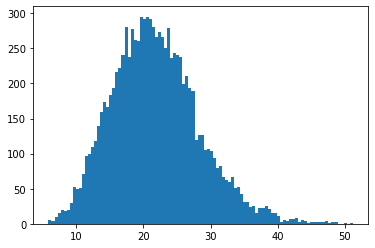

In [0]:
r = plt.hist(anomality, bins=100)

## Plot Reconstructed Images

选择baseline model，最好的两张最坏的两张

选择best model，最好的两张最坏的两张

由于图片像素的分布在-1到1之间，所以推测图片已经经过标准化处理，为了更好的显示图片，这里将图片先投影到0-1之间。

(array([1738970., 2939917., 3993573., 4235763., 4103525., 3769778.,
        3390553., 2689625., 1963095., 1895201.]),
 array([-0.990434  , -0.7919645 , -0.593495  , -0.3950255 , -0.19655599,
         0.00191352,  0.20038302,  0.39885253,  0.59732205,  0.7957915 ,
         0.994261  ], dtype=float32),
 <a list of 10 Patch objects>)

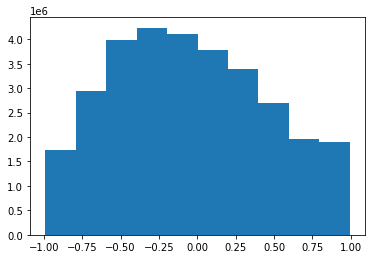

In [69]:
plt.hist(x_rec.reshape(-1))

In [0]:
def plot_rec_img(model_name):
    def project_img(img):
        img = img+np.abs(img.min())
        img = img / img.max()
        return img

    code, x_rec, anomality = test_model(model_name)
    idxes = anomality.argsort()
    print(x_rec.shape)
    idxes_base = [idxes[0], idxes[1], idxes[-1], idxes[-2]]
    fig,axs = plt.subplots(2,4, figsize=(10, 4))
    for i in range(4):
        idx = idxes_base[i]
        axs[0][i].imshow(project_img(test[idx]))
        axs[1][i].imshow(project_img(x_rec[idx]))
    
    return fig

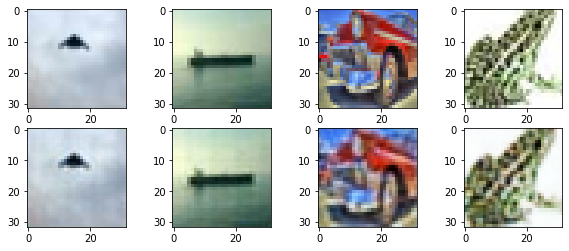

In [123]:
fig = plot_rec_img('base_line_cnn.pt')

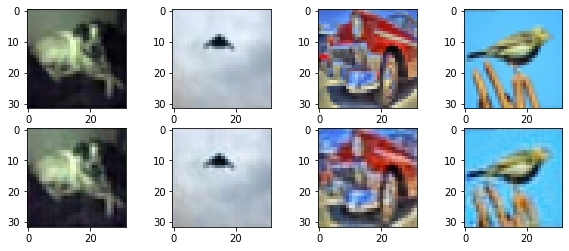

In [124]:
fig = plot_rec_img('best_model_cnn.pt')

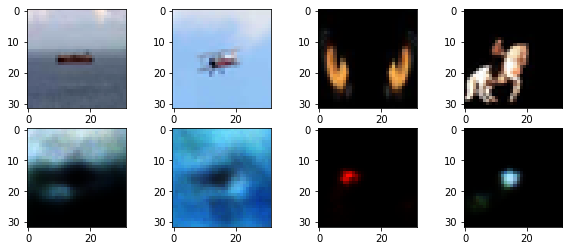

In [125]:
fig = plot_rec_img('best_model_vae.pt')

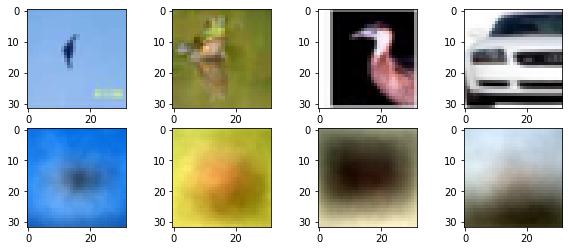

In [126]:
fig = plot_rec_img('best_model_fcn.pt')

(10000, 32, 32, 3)


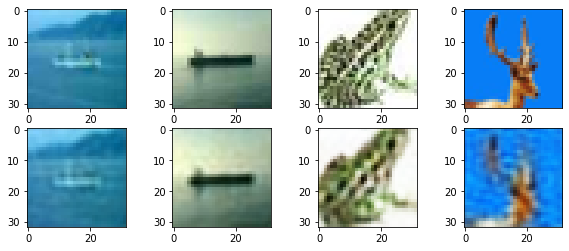

In [28]:
fig = plot_rec_img('best_model_cnnv2.pt')

结论：

上面的图从左到右分别是（最好的， 次好的，最差的，次差的）。你会发现，反直觉的，fcn kaggle得分最高，但是重构得不怎么好，cnn重构都很好。

从loss来看，fcn的loss为370， vae的loss为570，cnn的loss在10以下。这很可能只是decode太强。

## Use Knn and PCA to Reconstruction

这边打算进行对比，分别验证：

- PCA直接重构的结果，PCA对AE code 重构的结果，PCA重构cnn的latent code 0.58926
-  KNN对AE code进行聚类，test code与各个聚类中心的距离来判断，CNN based的code反而获得了非常高的分数60.5（原本模型54.8）， fcn只有57.1（59.7）

这至少说明，CNN的lantent code包含的特征是足够的，只是使用decode之后无法很好的区分异常数据。

PCA其实没必要看，因为它是可以考虑是一个train到最好的线性神经网络。

KNN对latent code聚类到9类，这件事是比较有效的。

In [0]:
def knn_rec(train, test):
    set_seed(0)
    #  确定knn分几类的 test rec loss最小
    x = train.reshape(len(train), -1)
    y = test.reshape(len(test), -1)
    scores = list()
    n = 9
    kmeans_x = MiniBatchKMeans(n_clusters=n, batch_size=100).fit(x)
    y_cluster = kmeans_x.predict(y)
    y_dist = np.sum(np.square(kmeans_x.cluster_centers_[y_cluster] - y), axis=1)

    y_pred = y_dist
    print(y_dist.mean())
    return y_dist

In [184]:
y_pred = knn_rec(train, test)
save_csv(y_pred, 'knn_img_rec.csv')

507.06796209384817


In [0]:
test_code, _, _ = test_model('best_model_cnn.pt')
train_code,_,_ = test_model('best_model_cnn.pt', data_mode='train')

In [186]:
y_pred = knn_rec(train_code, test_code)
save_csv(y_pred, 'knn_code_rec.csv')

667.2936


In [187]:
test_code, _, _ = test_model('best_model_fcn.pt')
train_code,_,_ = test_model('best_model_fcn.pt', data_mode='train')
print(train_code.shape)

(40000, 3)


In [188]:
y_pred = knn_rec(train_code, test_code)
save_csv(y_pred, 'knn_code_fcn_rec.csv')

51.417084


In [189]:
test_code, _, _ = test_model('best_model_vae.pt')
train_code,_,_ = test_model('best_model_vae.pt', data_mode='train')
print(train_code.shape)

(40000, 20)


In [190]:
y_pred = knn_rec(train_code, test_code)
save_csv(y_pred, 'knn_code_vae_rec.csv')

19.519007


In [181]:
train_code.shape

(40000, 20)

In [182]:
test_code.shape

(40000, 20)

In [0]:
def pca_rec(train, test):   
    x = train.reshape(len(train), -1)
    y = test.reshape(len(test), -1)
    pca = PCA(n_components=10).fit(x)

    y_projected = pca.transform(y)
    y_reconstructed = pca.inverse_transform(y_projected)  
    dist = np.sqrt(np.sum(np.square(y_reconstructed - y).reshape(len(y), -1), axis=1))
    
    y_pred = dist
    print(y_pred.mean())
    return y_pred

In [199]:
y_pred = pca_rec(train,test)
save_csv(y_pred, 'pca_img_rec.csv')

20.689198064711725


In [200]:
test_code, _, _ = test_model('best_model_cnn.pt')
train_code,_,_ = test_model('best_model_cnn.pt', data_mode='train')
y_pred = knn_rec(train_code, test_code)
save_csv(y_pred, 'knn_code_rec.csv')

667.2936


In [204]:
y_pred = pca_rec(train_code, test_code)
save_csv(y_pred, 'pca_code_rec.csv')

18.237724


## T-SNE Reduction to Visualization

反正我看不出什么，除非是那一小撮东西。

In [0]:
from sklearn.manifold import TSNE

In [0]:
def cluster(vec, show_plot = False):
  # 选择最佳的维度
  pca = PCA()
  pca.fit(vec)
  cumsum = np.cumsum(pca.explained_variance_ratio_)
  # d = np.argmax(cumsum>0.99)+1
  d = 200
  if show_plot:
    print(d)
    plt.plot(cumsum)
    plt.show()
  tfs = KernelPCA(n_components=d, kernel='rbf')
  vec_1 = tfs.fit_transform(vec)
  # print('Fisrt Reduction Shape:{}'.format(vec_1.shape))
  vec_2 = TSNE(n_components=2, random_state=0).fit_transform(vec_1)

  return vec_2,


In [0]:
def plot_scatter(feat, savefig=None):
    """ Plot Scatter Image.
    Args:
      feat: the (x, y) coordinate of clustering result, shape: (9000, 2)
      label: ground truth label of image (0/1), shape: (9000,)
    Returns:
      None
    """
    fig = plt.figure()
    X = feat[:, 0]
    Y = feat[:, 1]
    plt.scatter(X, Y, s=0.1)
    plt.legend(loc='best')
    if savefig is not None:
        plt.savefig(savefig)
    
    return fig


No handles with labels found to put in legend.


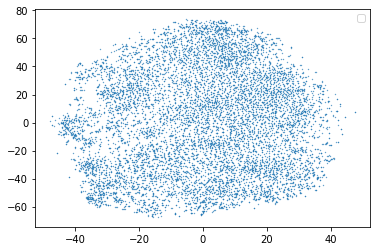

In [227]:
vec_red = cluster(test.reshape(test.shape[0], -1))
fig = plot_scatter(vec_red)

No handles with labels found to put in legend.


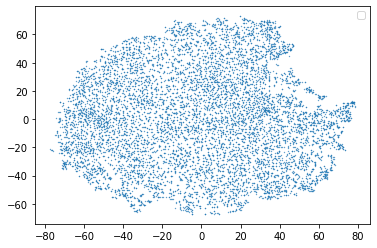

In [226]:
test_code, _, _ = test_model('base_line_cnn.pt')
vec_red = cluster(test_code)
fig = plot_scatter(vec_red)

No handles with labels found to put in legend.


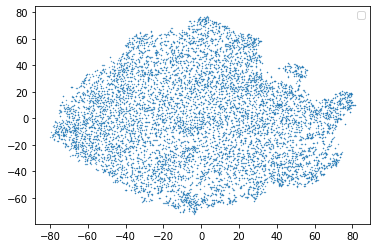

In [225]:
test_code, _, _ = test_model('best_model_cnn.pt')
vec_red = cluster(test_code)
fig = plot_scatter(vec_red)

No handles with labels found to put in legend.


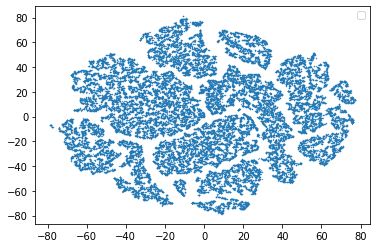

In [232]:
test_code, _, _ = test_model('best_model_fcn.pt', data_mode='train')
vec_red = cluster(test_code)
fig = plot_scatter(vec_red)

No handles with labels found to put in legend.


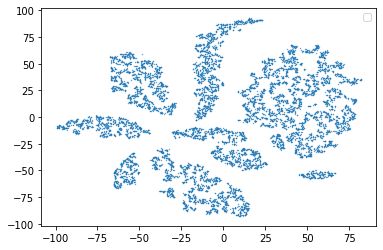

In [233]:
test_code, _, _ = test_model('best_model_fcn.pt', data_mode='test')
vec_red = cluster(test_code)
fig = plot_scatter(vec_red)

t-SNE出现这种结果并不代表分类器很好，而是本来就是在三维空间内的，不管分类结果的好坏，使用t-SNE会有非常强大的分离效果。

## Why AUC Score

AUC是ROC曲线的面积，ROC曲线是TPR和FPR在不同阈值下的曲线。AUC代表二分类器分类效果的分离程度，其结果只和正负分类中交错部分的数量有关，即和混淆样本的数量有关，和整体的正负样本比例关系不大。

而F1，本身是为了权衡Recall和Precision的一个指标，预测为正的样本越多，则召回正样本的值越大（recall）， 但于此同时，precision将会因为误判的样本增多而减小。F1值是二者的调和平均。但F1对数量很敏感。举个例子，假如负样本很少，100个中只有3个，你全部预测为正，那么此时recall为1，precision为0.97，可以知道F1必定也很高，但实际上这是一个很差的分类器，他把负样本全部分类错误！

## Strong Baseline

考虑到全连接层一维的特性很难捕获到更多的特征——这应该就是FC-AE和VAE-AE的loss很难降下去的原因。而CNN-AE的loss就很低，重构的也非常好，但是直接用CNN-AE的reconstruction mse来作为prediction，结果并不好。在实验中，我发现，CNN-AE的latent code直接进行聚类的话可以获得很强的效果。这可能说明了模型确实在encoder方面做得很好，但是由于decoder太强了，导致异常分类的loss也很低。

所以，我主要有两个改进思路

- Deeper CNN layer，然后用KNN在latent code上进行聚类。主要考虑更强大的CNN特征encoder能力更好，那么在latent code上进行聚类，可能能获得更好的聚类效果。考虑T-SNE结合KNN应该会有比较好的效果，因为KNN适合最后的聚类评估mse，而t-SNE适合在中长dim中降维到2维或者3维。

63.7

In [0]:
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
    		nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
          nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
            nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Tanh(),
        )

    def forward(self, x):
        # print(x.dtype)
        code = self.encoder(x)
        x_rec = self.decoder(code)
        return code,x_rec

In [17]:
model = conv_autoencoder().to(device)
print(summary(model, torch.zeros((1, 3,32,32)).to(device), show_hierarchical=True))

--------------------------------------------------------------------------
         Layer (type)        Output Shape         Param #     Tr. Param #
             Conv2d-1     [1, 12, 16, 16]             588             588
               ReLU-2     [1, 12, 16, 16]               0               0
             Conv2d-3       [1, 24, 8, 8]           4,632           4,632
               ReLU-4       [1, 24, 8, 8]               0               0
             Conv2d-5       [1, 48, 4, 4]          18,480          18,480
               ReLU-6       [1, 48, 4, 4]               0               0
             Conv2d-7       [1, 96, 2, 2]          73,824          73,824
               ReLU-8       [1, 96, 2, 2]               0               0
    ConvTranspose2d-9       [1, 48, 4, 4]          73,776          73,776
              ReLU-10       [1, 48, 4, 4]               0               0
   ConvTranspose2d-11       [1, 24, 8, 8]          18,456          18,456
              ReLU-12       [1, 24, 8

In [19]:
# cnn 2
num_epochs = 500
batch_size = 128
learning_rate = 1e-3
mode = 'cnnv2'
model = train_process(mode, learning_rate, batch_size, num_epochs)


3.53s,epoch [001/500], loss: 348.89887195
3.04s,epoch [002/500], loss: 165.03875972
2.51s,epoch [003/500], loss: 134.04979336
2.43s,epoch [004/500], loss: 122.31434722
2.59s,epoch [005/500], loss: 113.36343699
2.43s,epoch [006/500], loss: 105.18222468
2.65s,epoch [007/500], loss: 98.34746638
2.57s,epoch [008/500], loss: 93.63049651
2.46s,epoch [009/500], loss: 89.93062408
2.62s,epoch [010/500], loss: 85.56212122
2.37s,epoch [011/500], loss: 83.41743840
2.49s,epoch [012/500], loss: 80.82371288
2.58s,epoch [013/500], loss: 76.95878778
2.52s,epoch [014/500], loss: 73.06629141
2.35s,epoch [015/500], loss: 71.05516943
2.35s,epoch [016/500], loss: 69.17789599
2.36s,epoch [017/500], loss: 67.96401077
2.33s,epoch [018/500], loss: 66.41905360
2.53s,epoch [019/500], loss: 63.99340862
2.49s,epoch [020/500], loss: 62.64661970
2.32s,epoch [021/500], loss: 61.64971062
2.50s,epoch [022/500], loss: 60.24479892
2.33s,epoch [023/500], loss: 59.30667427
2.51s,epoch [024/500], loss: 58.71153098
2.38s,epoc

In [68]:
test_code, test_rec, _ = test_model('best_model_cnnv2.pt')
train_code,train_rec,_ = test_model('best_model_cnnv2.pt', data_mode='train')
print(train_code.shape)

(40000, 384)


In [69]:
y_pred = knn_rec(train_code, test_code)
save_csv(y_pred, 'knn_code_cnnv2_rec.csv')

1105.7747


fine-tuning

In [0]:
def train_process(mode, learning_rate, batch_size, num_epochs):
    set_seed(0)
    train_set = ImgDataset(train, mode = mode)
    loader = get_dataloader(train_set, mode = mode, batch_size=batch_size)
    model_classes = {'fcn':fcn_autoencoder(), 'cnn':conv_autoencoder(), 'vae':VAE(), 'cnnv2':conv_autoencoder()}
    model = model_classes[mode].to(device)
    criterion = nn.MSELoss(reduction = 'sum') if mode != 'vae' else loss_vae
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    for epoch in range(1, num_epochs+1):
        st = time.time()
        model.train()
        epoch_loss,_ = run_epoch(model, loader, criterion, optimizer, 'train', mode)
        ed = time.time()
        print('{:.2f}s,epoch [{:0>3d}/{}], loss: {:.8f}'
            .format(ed-st, epoch, num_epochs, epoch_loss/len(train_set)))
    return model

In [0]:
mode = 'cnnv2'
train_set = ImgDataset(train, mode = 'cnnv2')
criterion =  nn.MSELoss(reduction = 'sum')
model = torch.load(os.path.join(path, 'best_model_cnnv2.pt')).to(device)

In [0]:
# cnn
num_epochs = 50
batch_size = 128
learning_rate = 1e-4 # 50
learning_rate = 1e-5 # 50
loader = get_dataloader(train_set, mode = mode, batch_size=batch_size)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
best_loss = 21.39121349
best_loss =  21.25762392

In [0]:
for epoch in range(1, num_epochs+1):
    st = time.time()
    model.train()
    epoch_loss,_ = run_epoch(model, loader, criterion, optimizer, 'train', mode, best_loss= best_loss)
    ed = time.time()
    print('{:.2f}s,epoch [{:0>3d}/{}], loss: {:.8f}'
        .format(ed-st, epoch, num_epochs, epoch_loss/len(train_set)))
